### Libraries

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from umap import UMAP
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Corpus embedding

In [ ]:
def tokenizeCorpus(corpus, model=BertModel.from_pretrained('bert-base-uncased', 
                                                           output_hidden_states=True), 
                           tokenizer = BertTokenizer.from_pretrained('bert-base-uncased'), 
                           model_input_size=512):
    def flatten(l):
        return [item for sublist in l for item in sublist]
    input_size = model_input_size - 1
    corpusWords = corpus.split(" ")
    splited = [" ".join(corpusWords[i:i+input_size]) for i in range(0, len(corpusWords), input_size)]

    input_ids = []
    attention_masks = []
    for sentence in splited:
        encoded = tokenizer.encode_plus(sentence, 
                                        add_special_tokens=True,
                                        max_length=input_size+1,
                                        padding="max_length",
                                        return_attention_mask=True,
                                        return_tensors='pt',
                                        truncation=True)
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    #inputs_ids = torch.Tensor(len(input_ids),1, max_len+1)
    #torch.cat(input_ids, out=inputs_ids)
    inputs_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    temp = flatten([batch.tolist() for batch in input_ids])
    labels = np.array(temp)
    labels = labels.reshape((labels.shape[0]*labels.shape[1]))
    labels = tokenizer.convert_ids_to_tokens(labels)
    with torch.no_grad():
        output = model(inputs_ids, attention_mask=attention_masks)
    return output, labels

def vectorizeCorpus(model_output, allStates=True):
    if allStates==True:
        hidden_states = model_output.hidden_states
    else:
        hidden_states = [model_output.last_hidden_state]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = token_embeddings.permute(1,2,0,3)
    embs = []
    for batch in token_embeddings:
        for token in batch:
            emb = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
            embs.append(emb)
    return embs

def visualizeCorpus(embs, labels, embs_gold=None, labels_gold=None, dim=2):
    comp_gold = True if embs_gold != None and labels_gold != None else False

    formated_embs = [token.tolist() for token in embs]
    formated_embs = np.array(formated_embs)
    formated_embs_gold = [token.tolist() for token in embs_gold]
    formated_embs_gold = np.array(formated_embs_gold)
    token_indexes = [i for i in range(len(labels)) if labels[i] != "[PAD]" and labels[i] != "[CLS]" and labels[i] != "[SEP]" and len(labels[i])>2]

    if dim == 1:
        umap1D = UMAP(n_components=1, init='random', random_state=0)
        proj1D = umap1D.fit_transform(formated_embs).T

        data = {"x": proj1D[0],
                "labels": labels}
        
        for k in data.keys():
            data[k] = [data[k][i] for i in range(len(data[k])) if i in token_indexes]

        if comp_gold:
            token_indexes_gold = [i for i in range(len(labels_gold)) if labels_gold[i] != "[PAD]" and labels_gold[i] != "[CLS]" and labels_gold[i] != "[SEP]" and len(labels_gold[i])>2]
            proj1D_gold = umap1D.fit_transform(formated_embs_gold).T
            data_gold = {"x": proj1D_gold[0],
                        "labels": labels_gold}
            for k in data_gold.keys():
                data_gold[k] = [data_gold[k][i] for i in range(len(data_gold[k])) if i in token_indexes_gold]

        traces = []
        for i in range(len(data['x'])):
            if comp_gold:
                color = 'green' if data["labels"][i] in data_gold["labels"] else 'red'
            else:
                color = 'red'
            trace = go.Scatter(
                x=[data['x'][i]],
                mode='markers',
                marker=dict(size=6, color=color),
                text=[data['labels'][i]],
                name=data['labels'][i]
            )
            traces.append(trace)
        if comp_gold:
            for i in range(len(data_gold['x'])):
                trace = go.Scatter(
                    x=[data_gold['x'][i]],
                    mode='markers',
                    marker=dict(size=6, color='gold'),
                    text=[data_gold['labels'][i]],
                    name=data_gold['labels'][i]
                )
                traces.append(trace)

        layout = go.Layout(
            title='1D Scatter Plot',
            scene=dict(
                xaxis=dict(title='X')
            )
        )
        fig = go.Figure(data=traces, layout=layout)
        fig.show()

    elif dim == 2:
        umap2D = UMAP(n_components=2, init='random', random_state=0)
        proj2D = umap2D.fit_transform(formated_embs).T

        data = {"x": proj2D[0],
                "y": proj2D[1],
                "labels": labels}
        
        for k in data.keys():
            data[k] = [data[k][i] for i in range(len(data[k])) if i in token_indexes]

        if comp_gold:
            token_indexes_gold = [i for i in range(len(labels_gold)) if labels_gold[i] != "[PAD]" and labels_gold[i] != "[CLS]" and labels_gold[i] != "[SEP]" and len(labels_gold[i])>2]
            proj2D_gold = umap2D.fit_transform(formated_embs_gold).T
            data_gold = {"x": proj2D_gold[0],
                        "y": proj2D_gold[1],
                        "labels": labels_gold}
            for k in data_gold.keys():
                data_gold[k] = [data_gold[k][i] for i in range(len(data_gold[k])) if i in token_indexes_gold]

        traces = []
        for i in range(len(data['x'])):
            if comp_gold:
                color = 'green' if data["labels"][i] in data_gold["labels"] else 'red'
            else:
                color = 'red'
            trace = go.Scatter(
                x=[data['x'][i]],
                y=[data['y'][i]],
                mode='markers',
                marker=dict(size=6, color=color),
                text=[data['labels'][i]],
                name=data['labels'][i]
            )
            traces.append(trace)
        if comp_gold:
            for i in range(len(data_gold['x'])):
                trace = go.Scatter(
                    x=[data_gold['x'][i]],
                    y=[data_gold['y'][i]],
                    mode='markers',
                    marker=dict(size=6, color='gold'),
                    text=[data_gold['labels'][i]],
                    name=data_gold['labels'][i]
                )
                traces.append(trace)

        layout = go.Layout(
            title='2D Scatter Plot',
            scene=dict(
                xaxis=dict(title='X'),
                yaxis=dict(title='Y')
            )
        )
        fig = go.Figure(data=traces, layout=layout)
        fig.show()

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
dataset_url="https://drive.google.com/file/d/1Wd0M3qepNF6B4YwFYrpo7CaSERpudAG_/view?usp=share_link"
dataset_url='https://drive.google.com/uc?export=download&id=' + dataset_url.split('/')[-2]
dataset = pd.read_json(dataset_url, lines=True)
dataset = dataset.loc[:, ["text", "summary"]]

elem0 = dataset.iloc[0, 0]
print(elem0)

In [ ]:
gold0 = dataset.iloc[0, 1]
print(gold0)

In [ ]:
o, l = tokenizeCorpus(elem0)
ogold, lgold = tokenizeCorpus(gold0)
v = vectorizeCorpus(o)
vgold = vectorizeCorpus(ogold)
visualizeCorpus(v, l, vgold, lgold, dim=1)

### Clustering with HDBScan

In [5]:
import sys
sys.path.append(r"D:\COURS\A4\S8 - ESILV\Stage\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")

In [6]:
import hdbscan
from MARScore.utils import *
import pandas as pd
from matplotlib import cm

d:\COURS\A4\S8 - ESILV\Stage\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\COURS\A4\S8 - ESILV\Stage\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\.venv\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\COURS\A4\S8 - ESILV\Stage\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-abs

In [7]:
dataset_url="https://drive.google.com/file/d/1Wd0M3qepNF6B4YwFYrpo7CaSERpudAG_/view?usp=share_link"
dataset_url='https://drive.google.com/uc?export=download&id=' + dataset_url.split('/')[-2]
dataset = pd.read_json(dataset_url, lines=True)
dataset = dataset.loc[:, ["text", "summary"]]

In [8]:
elem0 = dataset.iloc[0, 0]
gold0 = dataset.iloc[0, 1]

In [9]:
o, l = tokenizeCorpus(elem0)
ogold, lgold = tokenizeCorpus(gold0)
v = vectorizeCorpus(o)
vgold = vectorizeCorpus(ogold)

In [10]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(v)
clabels = clusterer.labels_

In [11]:
len(clabels)

2560

C:\Users\orteg\AppData\Local\Temp\ipykernel_20140\2292762520.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(set(clabels)))


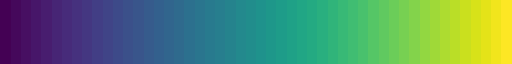

In [12]:

cmap = cm.get_cmap('viridis', len(set(clabels)))
cmap

In [13]:
len(cmap.colors)

50

In [14]:
visualizeCorpus(v, l, vgold, lgold, clabels, dim=2)

### Colorize clusters

In [ ]:
a = ["dd", "e"]

In [ ]:
a != None